In [1]:
import re
import pandas as pd
import numpy as np
from tqdm import tqdm

In [2]:
houses_df = pd.read_csv('syd_sold_property_all.csv')

# 1.Remove Duplicates

In [3]:
houses_df.shape

(21239, 19)

In [4]:
houses_df.duplicated().sum()

42

In [5]:
houses_df.drop_duplicates(inplace=True)

In [6]:
houses_df.shape

(21197, 19)

# 2.Missing Values

In [14]:
houses_df['landArea'] = houses_df['landArea'].replace(0, np.nan)

In [47]:
missing_data = houses_df.isnull()
for column in missing_data.columns.values.tolist():
    print(column)
    print(missing_data[column].value_counts())
    print()

soldPrice
False    21194
Name: soldPrice, dtype: int64

landArea
False    13232
True      7962
Name: landArea, dtype: int64

priceSource
False    21194
Name: priceSource, dtype: int64

soldYear
False    21194
Name: soldYear, dtype: int64

propertyPrice
False    21194
Name: propertyPrice, dtype: int64

address
False    21194
Name: address, dtype: int64

unitNumber
True     13348
False     7846
Name: unitNumber, dtype: int64

streetNumber
False    21165
True        29
Name: streetNumber, dtype: int64

suburb
False    21194
Name: suburb, dtype: int64

postcode
False    21194
Name: postcode, dtype: int64

lat
False    21194
Name: lat, dtype: int64

lng
False    21194
Name: lng, dtype: int64

rooms
False    21194
Name: rooms, dtype: int64

baths
False    21194
Name: baths, dtype: int64

parking
False    21194
Name: parking, dtype: int64

landSize
False    21194
Name: landSize, dtype: int64

landUnit
False    21194
Name: landUnit, dtype: int64

propertyType
False    21194
Name: propertyType,

In [8]:
# simply drop whole row with NaN in "lng lat" column
houses_df.dropna(subset=["lng","lat"], axis=0, inplace=True)

# reset index
houses_df.reset_index(drop=True, inplace=True)

In [49]:
houses_df.shape

(21194, 19)

Some landArea is 0, we can replace them with average area in corresponding property Types

*We can't filter np.nan, so we replace them back to 0*

In [51]:
houses_df['landArea'] = houses_df['landArea'].replace(np.nan, 0)

In [54]:
df_have_landarea = houses_df[houses_df.landArea!=0]

(13232, 19)

In [86]:
landArea_dict = df_have_landarea.groupby('propertyType')['landArea'].mean().to_dict()

propertyType_list = ['house', 'apartmentUnitFlat', 'townhouse', 'semiDetached', 'vacantLand',
       'villa', 'duplex', 'acreageSemiRural', 'terrace', 'newHouseLand',
       'studio', 'blockOfUnits', 'newApartments', 'rural', 'newLand',
       'developmentSite', 'carspace']

def replace_missing_landArea(houses_df):
    tmp_list = np.array(houses_df['landArea'])
    for pt in propertyType_list:
        pt_index = houses_df[(houses_df.landArea==0)&(houses_df.propertyType==pt)].index
        count_pt = pt_index.shape[0]
        if count_pt:
            tmp_list[pt_index] = [landArea_dict[pt]] * count_pt
    houses_df['landArea'] = tmp_list
    return houses_df

In [87]:
filled_houses_df = replace_missing_landArea(houses_df)

In [88]:
filled_houses_df[filled_houses_df.landArea==0]

,soldPrice,landArea,priceSource,soldYear,propertyPrice,address,unitNumber,streetNumber,suburb,postcode,lat,lng,rooms,baths,parking,landSize,landUnit,propertyType,schools
8021,646500,0.0,median,2021,630000,"12/442 King Georges Road, Beverly Hills NSW 2209",12,442,Beverly Hills,2209,-33.947415,151.079334,2,2,2,0,m²,penthouse,"[{'id': '8022', 'educationLevel': 'primary', '..."


In [89]:
filled_houses_df = filled_houses_df[filled_houses_df.landArea!=0]

In [94]:
# reset index, because we droped one rows
filled_houses_df.reset_index(drop=True, inplace=True)

In [96]:
filled_houses_df.shape

(21193, 19)

# 3.outlier Management

<AxesSubplot:>

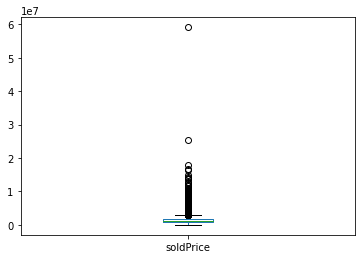

In [99]:
filled_houses_df['soldPrice'].plot(kind='box')

In [100]:
percentile25 = filled_houses_df['soldPrice'].quantile(0.25)
percentile75 = filled_houses_df['soldPrice'].quantile(0.75)
IQR = percentile75 - percentile25
upper_limit = percentile75 + 1.5 * IQR
lower_limit = percentile25 - 1.5 * IQR

In [101]:
filled_houses_df[(filled_houses_df['soldPrice'] < upper_limit) & (filled_houses_df['soldPrice'] >= lower_limit)].shape

(19931, 19)

In [102]:
clean_house_df = filled_houses_df[(filled_houses_df['soldPrice'] < upper_limit) & (filled_houses_df['soldPrice'] >= lower_limit)]

# Save dataset

In [103]:
clean_house_df.to_csv('clean_syd_sold_all.csv',index=False)